# k-Nearest Neighbor

## Results

### Histogram

| Image type | Bin size | Memory usage | Prediction time | Accuracy|
|:----------:|:--------:|:------------:|:---------------:|:-------:|
| Normal | (32, 32, 32) | 430.18 [MB] | 0.452 [s] | 92.5 % |
| Filtered | (8, 8, 8) | 6.72 [MB] | 0.0120 [s] | 98.5 % |

## Setup stuff

In [1]:
###### IMPORTS ######
import os
import glob
from imutils import paths
import cv2
import numpy as np
import matplotlib.pyplot as plt
from knn_classifier import kNearestNeighbor

from util import time_function, extract_hist, image_to_feature_vector, convert_label_to_number
from util import cross_val, print_info, plot_image_samples, multiband_threshold, smooth

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
###### GLOBAL VARIABLES ######
# Labels
BACKGROUND = 0
POTATO = 1
CARROT = 2
CAT_SAL = 3
BUN = 4
ARM = 5
KETCHUP = 6

# Background mask
BGD_MASK = cv2.imread('../preprocessing/bgd_mask.jpg', cv2.IMREAD_COLOR)

# Average background image
AVG_BGD_MASK = cv2.imread('../preprocessing/avg_background.jpg', cv2.IMREAD_COLOR)

# Test directories
BGD_TEST_DIR = glob.glob('../dataset3/res_still/test/background/*.jpg')
POTATO_TEST_DIR = glob.glob('../dataset3/res_still/test/potato/*.jpg')
CARROT_TEST_DIR = glob.glob('../dataset3/res_still/test/carrots/*jpg')
CAT_SAL_TEST_DIR = glob.glob('../dataset3/res_still/test/catfood_salmon/*.jpg')
BUN_TEST_DIR = glob.glob('../dataset3/res_still/test/bun/*.jpg')
ARM_TEST_DIR = glob.glob('../dataset3/res_still/test/arm/*.jpg')
KETCHUP_TEST_DIR = glob.glob('../dataset3/res_still/test/ketchup/*.jpg')

# Train directories
BGD_TRAIN_DIR = glob.glob('../dataset3/res_still/train/background/*.jpg')
POTATO_TRAIN_DIR = glob.glob('../dataset3/res_still/train/potato/*.jpg')
CARROT_TRAIN_DIR = glob.glob('../dataset3/res_still/train/carrots/*jpg')
CAT_SAL_TRAIN_DIR = glob.glob('../dataset3/res_still/train/catfood_salmon/*.jpg')
BUN_TRAIN_DIR = glob.glob('../dataset3/res_still/train/bun/*.jpg')
ARM_TRAIN_DIR = glob.glob('../dataset3/res_still/train/arm/*.jpg')
KETCHUP_TRAIN_DIR = glob.glob('../dataset3/res_still/train/ketchup/*.jpg')

## Full images histogram

- Bin size = (32, 32, 32)

In [3]:
def import_data(X, y, folder, label, show_img):
    """ Imports data """
    
    if show_img is True:
        images = []

    for i, img in enumerate(folder):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.bitwise_and(img, BGD_MASK)

        # Extract histogram
        hist = extract_hist(img, bins=(32, 32, 32))

        X.append(hist)
        y.append(label)

        if show_img is True:
            image = cv2.resize(img, (448, 448), interpolation=cv2.INTER_CUBIC)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

    if show_img is True:
        return images

# Import train data
X_train = []
y_train = []

import_data(X_train, y_train, BGD_TRAIN_DIR, 0, False)
import_data(X_train, y_train, POTATO_TRAIN_DIR, 1, False)
import_data(X_train, y_train, CARROT_TRAIN_DIR, 2, False)
import_data(X_train, y_train, CAT_SAL_TRAIN_DIR, 3, False)
import_data(X_train, y_train, BUN_TRAIN_DIR, 5, False)
import_data(X_train, y_train, ARM_TRAIN_DIR, 6, False)
import_data(X_train, y_train, KETCHUP_TRAIN_DIR, 7, False)

# Import test data
X_test = []
y_test = []

import_data(X_test, y_test, BGD_TEST_DIR, 0, False)
import_data(X_test, y_test, POTATO_TEST_DIR, 1, False)
import_data(X_test, y_test, CARROT_TEST_DIR, 2, False)
import_data(X_test, y_test, CAT_SAL_TEST_DIR, 3, False)
import_data(X_test, y_test, BUN_TEST_DIR, 5, False)
import_data(X_test, y_test, ARM_TEST_DIR, 6, False)
import_data(X_test, y_test, KETCHUP_TEST_DIR, 7, False)


Information:

Train matrix: 430.178304 MB
Test matrix: 108.265472 MB
Train data shape: (1641, 32768)
Tain labels shape: (1641,)
Test data shape: (413, 32768)
Test labels shape: (413,)
Distance shape: (413, 1641)


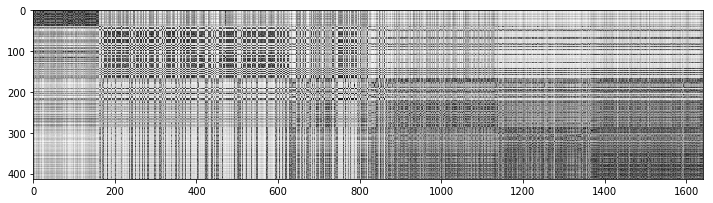

Average time performance: 0.45160618623097737 seconds


In [4]:
# Informatoin
print('\nInformation:\n')
X_train, y_train, X_test, y_test = print_info(X_train, y_train, X_test, y_test)


Cross-validation:



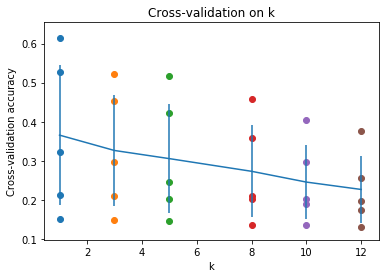

In [5]:
# Cross-validation
print('\nCross-validation:\n')

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12]

X_train_hist_folds = []
X_train_pixel_folds = []
y_train_folds = []

# Split training data into folds
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

cross_val(k_choices, num_folds, X_train_folds, y_train_folds, X_test.shape[0])

In [13]:
# Best value of k
print('\nkNN with the best value of k:')
best_k = 1

classifier = kNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('\nGot %d / %d correct' % (num_correct, X_test.shape[0]))
print('Accuracy: %f' % accuracy)


kNN with the best value of k:

Got 382 / 413 correct
Accuracy: 0.924939


In [18]:
# Remove X_train, y_train, X_test, y_test from memory
del X_train
del y_train
del X_test
del y_test

## Full images histogram

- bin size = (8, 8, 8)
- Multiband thresholding

In [19]:
def import_data(X, y, folder, label, show_img):
    """ Imports data """
    
    if show_img is True:
        images = []

    for i, img in enumerate(folder):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.bitwise_and(img, BGD_MASK)
        
        # Multiband thresholding
        img = multiband_threshold(img)

        # Extract histogram
        hist = extract_hist(img, bins=(8, 8, 8))

        X.append(hist)
        y.append(label)

        if show_img is True:
            image = cv2.resize(img, (448, 448), interpolation=cv2.INTER_CUBIC)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

    if show_img is True:
        return images

# Import train data
X_train = []
y_train = []

import_data(X_train, y_train, BGD_TRAIN_DIR, 0, False)
import_data(X_train, y_train, POTATO_TRAIN_DIR, 1, False)
import_data(X_train, y_train, CARROT_TRAIN_DIR, 2, False)
import_data(X_train, y_train, CAT_SAL_TRAIN_DIR, 3, False)
import_data(X_train, y_train, BUN_TRAIN_DIR, 5, False)
import_data(X_train, y_train, ARM_TRAIN_DIR, 6, False)
import_data(X_train, y_train, KETCHUP_TRAIN_DIR, 7, False)

# Import test data
X_test = []
y_test = []

import_data(X_test, y_test, BGD_TEST_DIR, 0, False)
import_data(X_test, y_test, POTATO_TEST_DIR, 1, False)
import_data(X_test, y_test, CARROT_TEST_DIR, 2, False)
import_data(X_test, y_test, CAT_SAL_TEST_DIR, 3, False)
import_data(X_test, y_test, BUN_TEST_DIR, 5, False)
import_data(X_test, y_test, ARM_TEST_DIR, 6, False)
import_data(X_test, y_test, KETCHUP_TEST_DIR, 7, False)


Information:

Train matrix: 6.721536 MB
Test matrix: 1.691648 MB
Train data shape: (1641, 512)
Tain labels shape: (1641,)
Test data shape: (413, 512)
Test labels shape: (413,)
Distance shape: (413, 1641)


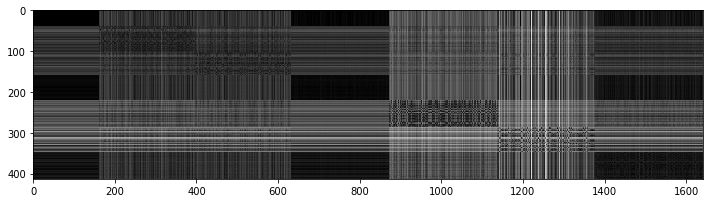

Average time performance: 0.011958901087443035 seconds


In [20]:
# Informatoin
print('\nInformation:\n')
X_train, y_train, X_test, y_test = print_info(X_train, y_train, X_test, y_test)


Cross-validation:



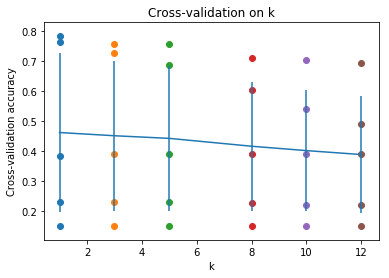

In [21]:
# Cross-validation
print('\nCross-validation:\n')

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12]

X_train_hist_folds = []
X_train_pixel_folds = []
y_train_folds = []

# Split training data into folds
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

cross_val(k_choices, num_folds, X_train_folds, y_train_folds, X_test.shape[0])

In [22]:
# Best value of k
print('\nkNN with the best value of k:')
best_k = 1

classifier = kNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('\nGot %d / %d correct' % (num_correct, X_test.shape[0]))
print('Accuracy: %f' % accuracy)


kNN with the best value of k:

Got 407 / 413 correct
Accuracy: 0.985472


In [ ]:
# Remove X_train, y_train, X_test, y_test from memory
del X_train
del y_train
del X_test
del y_test